In [1]:
import pandas as pd
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
# import folium

import contextily as ctx
from shapely.geometry import Point



df = pd.read_csv('../../../data/Apartments/listings_data_m2_medellin_2025-01-26.csv')

In [ ]:

# Extract longitude and latitude from the 'coordinates' column
df['coordinates'] = df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['lon'] = df['coordinates'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)
df['lat'] = df['coordinates'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)


# Drop rows with missing coordinates
df = df[(df['lon'] != 0.0) & (df['lat'] != 0.0)]

df_map = df.dropna(subset=['lon', 'lat'])



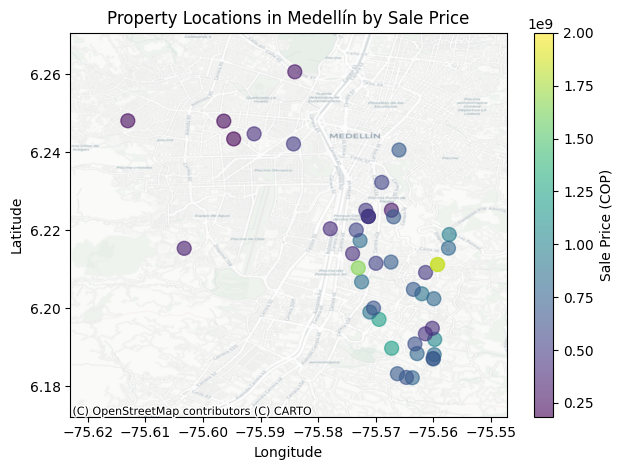

In [4]:



# Create figure and axis with larger size
fig, ax = plt.subplots() #(figsize=(12, 12))

# Create scatter plot with price-based coloring
scatter = plt.scatter(df_map['lon'], df_map['lat'], 
                     c=df_map['salePrice'],
                     cmap='viridis',
                     alpha=0.6,
                     s=100)

# Add colorbar
plt.colorbar(scatter, label='Sale Price (COP)')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property Locations in Medellín by Sale Price')

# Add background map
# try:
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)
# except:
#     plt.grid(True)  # Fallback to grid if basemap fails
#     plt.grid(True)  # Fallback to grid if basemap fails

# Adjust plot limits to focus on Medellín
plt.xlim(df_map['lon'].min() - 0.01, df_map['lon'].max() + 0.01)
plt.ylim(df_map['lat'].min() - 0.01, df_map['lat'].max() + 0.01)

plt.tight_layout()
plt.show()

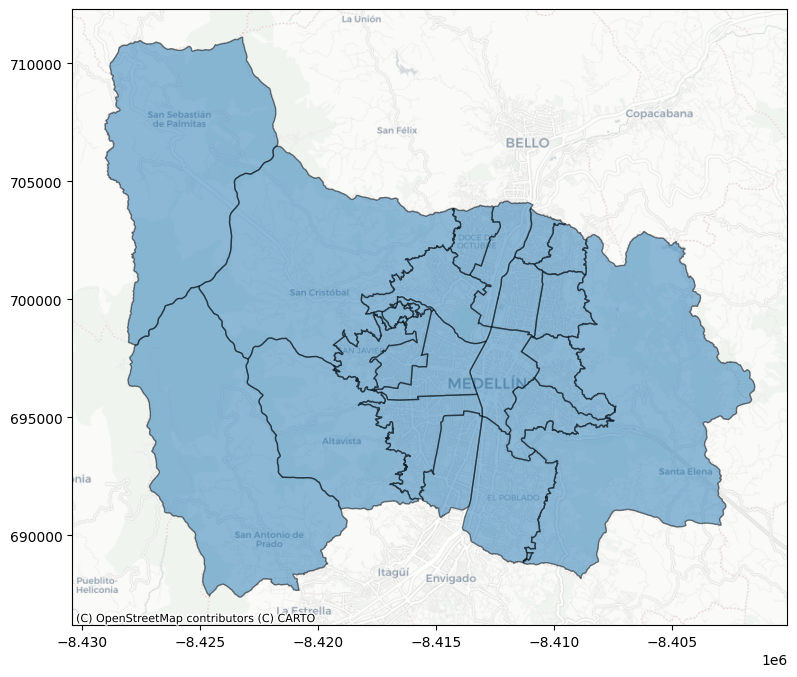

In [5]:
# Load the shapefile
gdf = gpd.read_file('shp_comunas_y_corregimientos_/comunas_y_corregimientos_.shp')
gdf = gdf.drop(columns=['fecha_actu'])

ax = gdf.to_crs(epsg=3857).plot(figsize=(10, 8), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()


In [6]:

# Ensure gdf is in the same CRS as the coordinates (EPSG:4326)
gdf_4326 = gdf.to_crs(epsg=4326)

# Create geometry column in df_map
df_map['geometry'] = df_map.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Convert df_map to GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_map, geometry='geometry', crs='EPSG:4326')

# Spatial join to get neighbourhood names
gdf_points = gpd.sjoin(gdf_points, gdf_4326[['nombre', 'geometry']], how='left', predicate='within')

# Add the neighbourhood name from gdf as a new column
df_map['neighbourhood_from_shape'] = gdf_points['nombre']

In [7]:
df_map.keys()

Index(['propertyId', 'propertyType', 'salePrice', 'area', 'areac', 'rooms',
       'bathrooms', 'garages', 'city', 'zone', 'neighborhood',
       'commonNeighborhood', 'adminPrice', 'companyName', 'propertyState',
       'coordinates', 'link', 'builtTime', 'stratum', 'Extraction Date', 'lon',
       'lat', 'geometry', 'neighbourhood_from_shape'],
      dtype='object')

In [8]:
# Calculate average salePrice for each neighbourhood in df_map
avg_price_by_neigh = df_map.groupby('neighbourhood_from_shape')['salePrice'].mean()

# Map the average price to the gdf_4326 GeoDataFrame based on 'nombre'
gdf_4326['avg_price'] = gdf_4326['nombre'].map(avg_price_by_neigh)

gdf_4326['avg_price'] = gdf_4326['avg_price'].fillna(0)

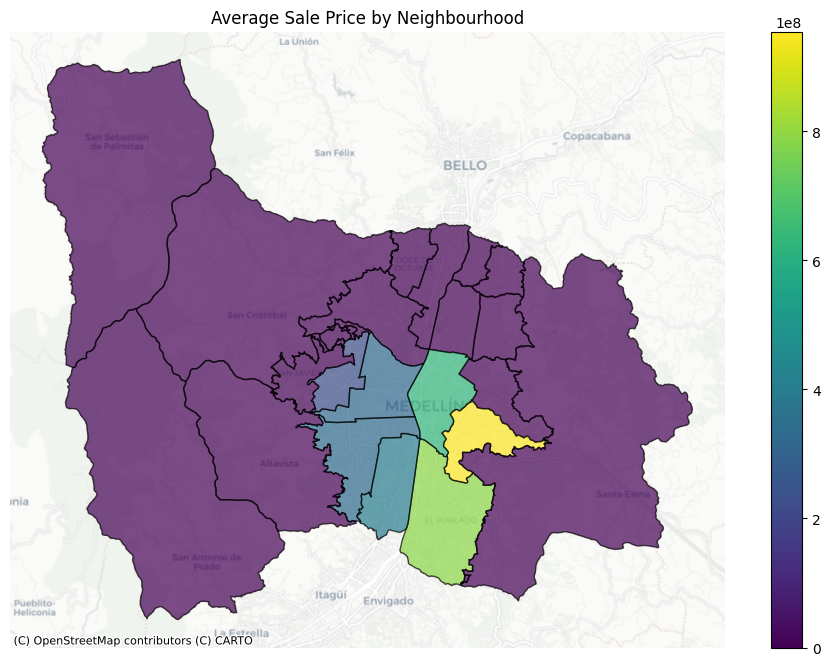

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf_4326.plot(column='avg_price', ax=ax, legend=True, cmap='viridis', edgecolor='k', alpha=0.7)
ctx.add_basemap(ax, crs=gdf_4326.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title('Average Sale Price by Neighbourhood')
plt.axis('off')
plt.show()

In [9]:
gdf_4326

,codigo,nombre,identifica,limitemuni,subtipo_co,Shape_Leng,Shape_Area,geometry,avg_price
0,01,Popular,Comuna 1,001,1,9604.447484,3.097941e+06,"POLYGON ((-75.54803 6.30436, -75.54795 6.30431...",0.0
1,02,Santa Cruz,Comuna 2,001,1,8597.293652,2.195663e+06,"POLYGON ((-75.55703 6.31007, -75.55699 6.31003...",0.0
2,03,Manrique,Comuna 3,001,1,12077.558708,5.096182e+06,"POLYGON ((-75.54252 6.28632, -75.54252 6.28632...",0.0
3,04,Aranjuez,Comuna 4,001,1,9642.676522,4.883314e+06,"POLYGON ((-75.56229 6.29126, -75.56221 6.29125...",0.0
4,05,Castilla,Comuna 5,001,1,16098.031666,6.063916e+06,"POLYGON ((-75.56566 6.31261, -75.56559 6.31259...",0.0
5,06,Doce de Octubre,Comuna 6,001,1,10709.846514,3.849812e+06,"POLYGON ((-75.57586 6.31093, -75.57584 6.31092...",0.0
6,07,Robledo,Comuna 7,001,1,23265.232357,9.462008e+06,"POLYGON ((-75.5905 6.29592, -75.59049 6.2959, ...",0.0
7,08,Villa Hermosa,Comuna 8,001,1,16392.858637,5.716968e+06,"POLYGON ((-75.55077 6.26237, -75.55071 6.26237...",0.0
8,09,Buenos Aires,Comuna 9,001,1,18364.901234,6.052668e+06,"POLYGON ((-75.55502 6.24505, -75.55501 6.24504...",955000000.0
9,10,La Candelaria,Comuna 10,001,1,13632.701742,7.360811e+06,"POLYGON ((-75.56426 6.26394, -75.56412 6.26393...",625000000.0
